# Architecture aware phase polynomial synthesis notebook


### Utility functions

Adjust the width of the notebook to the width of the screen (useful for wide screen monitors or other non-standard screen sizes)

In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

Create a function that will help display the progress of a function.

In [2]:
from IPython.display import clear_output

def progress_bar(progress, bar_length=20, prefix=""):
    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.2f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(prefix, text)

## Generate phase polynomials


In [3]:
import os

from phase_poly import make_random_phase_poly

In [4]:
def generate_phase_polynomials(folder, n_maps, n_qubits, n_gadgets):
    n_iters = n_maps*len(n_qubits)*len(n_gadgets)
    k = 0
    for q in n_qubits:
        for p in n_gadgets:
            dest_folder = os.path.join(folder, str(q) + "qubits", str(p)+"gadgets")
            os.makedirs(dest_folder, exist_ok=True)
            for i in range(n_maps):
                progress_bar(k/n_iters)
                filename = "Original" + str(i) + ".qasm"
                dest_file = os.path.join(dest_folder, filename)
                circuit = make_random_phase_poly(q, p, True)
                with open(dest_file, "w") as f:
                    f.write(circuit.to_qasm())
                k += 1
    progress_bar(k/n_iters)

In [ ]:
folder = "circuits/notebook/"
generate_phase_polynomials(folder, 20, [9, 25, 49, 64], [100])

In [ ]:
folder = "circuits/notebook/"
generate_phase_polynomials(folder, 20, [16, 20, 36], [1, 5, 10, 50, 100, 500, 1000])

## Route phase polynomials

In [5]:
import os
import pandas as pd

from phase_poly_router import route_with, PROPOSED, NASH, STAQ, TKET
from architecture import create_architecture, FULLY_CONNECTED, LINE, SQUARE, IBMQ_SINGAPORE, RIGETTI_16Q_ASPEN
from utils import get_metrics

In [6]:
def batch_route(folder, n_gadgets, architectures, methods, staq_mapped=False):
    results = []
    n_iters = len(n_gadgets)*len(architectures)*len(methods)*20
    i = 0
    prefix = " ".join(["Synthesising for architecture(s):"] + [a.name for a in architectures] + ["\n"]) 
    for architecture in architectures:
        n_qubits = architecture.n_qubits
        for gadgets in n_gadgets:
            path = os.path.join(folder,"{0}qubits".format(n_qubits), "{0}gadgets".format(gadgets))
            sources = [os.path.join(path, f) for f in os.listdir(path)] # Get all files in the folder "path"
            sources = [source for source in sources if os.path.isfile(source)] # Only get the files in the folder
            for filename in sources:
                for method in methods:
                    progress_bar(i/n_iters, prefix=prefix)
                    circuit, time = route_with(filename, architecture, method, mapped=staq_mapped)
                    metrics = get_metrics(circuit)
                    metrics["time"] = time
                    metrics["filename"] = filename 
                    metrics["gadgets"] = gadgets
                    metrics["qubits"] = n_qubits
                    metrics["architecture"] = architecture.name
                    metrics["method"] = method
                    results.append(metrics)
                    i += 1
    progress_bar(i/n_iters, prefix=prefix)
    return pd.concat(results)

### Real architecture experiments w/o qubit allocation

In [ ]:
all_results = []
for name in [RIGETTI_16Q_ASPEN, IBMQ_SINGAPORE]:
    results = batch_route("circuits/", [1,5,10,50,100,500,1000], [create_architecture(name)], [PROPOSED, STAQ, TKET])
    results.to_csv(name + "_gadget_scaling.csv")
    all_results.append(results)
pd.concat(all_results)

### Real architecture experiments w/qubit allocation

In [ ]:
all_results = []
for name in [RIGETTI_16Q_ASPEN, IBMQ_SINGAPORE]:
    results = batch_route("circuits/", [1,5,10,50], [create_architecture(name)], [PROPOSED, STAQ, TKET], staq_mapped=True)
    results.to_csv(name + "_gadget_scaling_with_mapping.csv")
    all_results.append(results)
pd.concat(all_results)

### Qubit scaling experiments
These regular, but non-existing architectures have not been implemented in Staq, therefore, we use our own implementation of the Nash et al. algorithm instead.

In [ ]:
all_results = []
for name in [LINE, SQUARE, FULLY_CONNECTED]:
    dynamic_architectures = [create_architecture(name, n_qubits=q) for q in [9, 16, 25, 36, 49, 64]]
    results = batch_route("circuits/", [100], dynamic_architectures, [PROPOSED, NASH, TKET])
    results.to_csv(name + "_qubit_scaling.csv")
    all_results.append(results)
pd.concat(all_results)

### Gadget scaling experiments
These regular, but non-existing architectures have not been implemented in Staq, therefore, we use our own implementation of the Nash et al. algorithm instead.

In [ ]:
all_results = []
for name in [LINE, SQUARE, FULLY_CONNECTED]:
    results = batch_route("circuits/", [1,5,10,50,100,500,1000], [create_architecture(name, n_qubits=36)], [PROPOSED, NASH, TKET])
    results.to_csv(name + "_gadget_scaling.csv")
    all_results.append(results)
pd.concat(all_results)

## Aggregate and visualise the results

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

from phase_poly_router import PROPOSED, NASH, STAQ, TKET

In [8]:
QUBIT_SCALING = "qubits"
GADGET_SCALING = "# Rz"

xlabel_dict = {
    QUBIT_SCALING : "# qubits",
    GADGET_SCALING : "# phase gadgets"
}
ylabel_dict = {
    "# CX": "CNOT count", 
    "CX depth": "CNOT depth", 
    "time": "Time in seconds"
}
legend_dict = {
    PROPOSED: "Proposed",
    TKET: "t|ket> w/ placement",
    NASH: "Steiner-GraySynth",
    STAQ: "Staq w/ steiner w/o placement"
}
def plot_results(filename, xlabel, methods, title, ylabels=["# CX", "CX depth", "time"], xlog=False, ylog=False, ylim=None):
    if isinstance(filename, str):
        df = pd.read_csv(filename)
    else:
        df = filename
    df.time = pd.to_timedelta(df.time).apply(lambda x: x.total_seconds()) # Make TimeDelta object into seconds
    fig, axes = plt.subplots(1,3,figsize=(12,4))
    fig.tight_layout(pad=3)
    #fig.suptitle(title)
    for ylabel, ax in zip(ylabels, axes):
        #ax.set_title(ylabel_dict[ylabel])
        ax.set_xlabel(xlabel_dict[xlabel])
        ax.set_ylabel(ylabel_dict[ylabel])
        if xlog:
            ax.set_xscale('log')
        if ylog:
            ax.set_yscale('log')
        if ylim is not None:
            ax.set_ylim(0, ylim)
        temp_df = df.groupby([xlabel, "method"]).mean()[ylabel].unstack()
        temp_df.sort_index(inplace=True)
        X = temp_df.index
        for method in methods:
            ax.plot(X, temp_df[method])
        ax.legend([legend_dict[m] for m in methods], loc=2)
        print(filename, ylabel_dict[ylabel])
        print(temp_df)
    fig.show()
    fig.savefig(filename[:-4] + ".pdf")

<IPython.core.display.Javascript object>


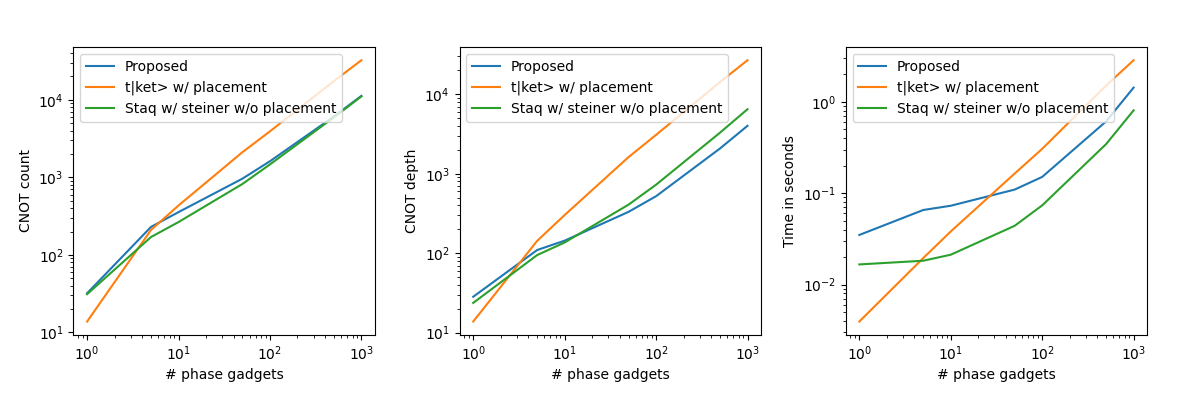

data/rigetti_16q_aspen_gadget_scaling.csv CNOT count
method  proposed      staq      tket
# Rz                                
1          32.00     31.10     13.80
5         229.30    169.85    209.55
10        355.80    264.80    433.25
50        961.05    820.80   2109.35
100      1611.90   1466.85   3917.60
500      6081.30   5928.60  17416.70
1000    11238.30  11043.40  32357.05
data/rigetti_16q_aspen_gadget_scaling.csv CNOT depth
method  proposed     staq      tket
# Rz                               
1          28.30    23.70     13.80
5         109.70    94.70    142.95
10        143.95   136.45    302.65
50        331.90   409.00   1622.45
100       522.05   728.80   3090.60
500      2082.25  3293.90  14274.65
1000     4018.20  6500.05  26896.25
data/rigetti_16q_aspen_gadget_scaling.csv Time in seconds
method  proposed      staq      tket
# Rz                                
1       0.034938  0.016630  0.003943
5       0.065515  0.018245  0.019514
10      0.072943  0.021245  0.0

<IPython.core.display.Javascript object>


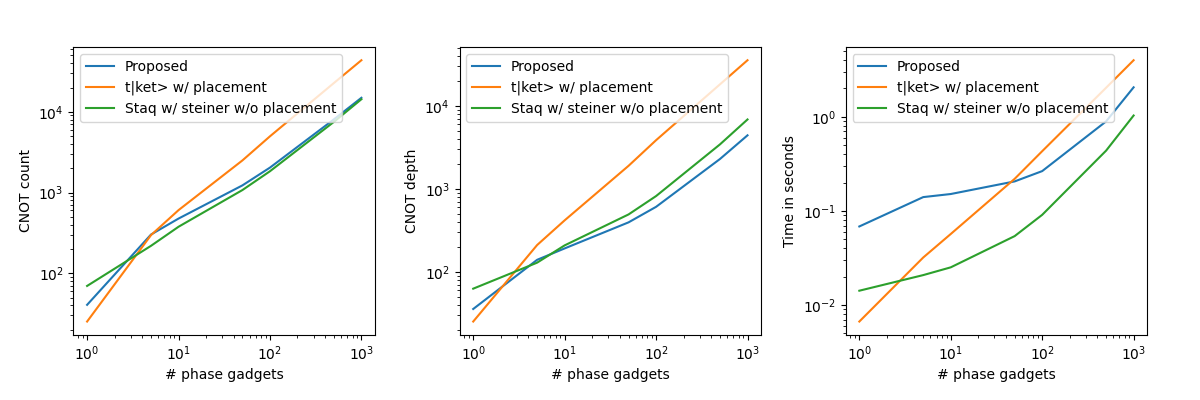

data/ibmq_singapore_gadget_scaling.csv CNOT count
method  proposed      staq      tket
# Rz                                
1          40.60     69.60     25.20
5         301.60    218.60    296.70
10        475.50    376.50    604.95
50       1226.00   1073.25   2499.30
100      2035.10   1834.75   4969.60
500      8054.35   7498.85  22710.00
1000    14908.55  14309.70  43538.10
data/ibmq_singapore_gadget_scaling.csv CNOT depth
method  proposed     staq     tket
# Rz                              
1          35.70    62.75     25.2
5         139.75   129.15    210.6
10        191.75   208.60    417.9
50        395.20   492.40   1897.7
100       607.95   819.65   3863.9
500      2293.45  3440.55  18205.9
1000     4422.70  6867.05  35533.3
data/ibmq_singapore_gadget_scaling.csv Time in seconds
method  proposed      staq      tket
# Rz                                
1       0.068425  0.014222  0.006692
5       0.140266  0.020833  0.032037
10      0.151223  0.025188  0.056913
50      0.20

In [9]:
plot_results("data/rigetti_16q_aspen_gadget_scaling.csv", GADGET_SCALING, [PROPOSED, TKET, STAQ], "Scaling of the number of phase gadgets on the 16 qubit Rigetti Aspen architecture", xlog=True, ylog=True)
plot_results("data/ibmq_singapore_gadget_scaling.csv", GADGET_SCALING, [PROPOSED, TKET, STAQ], "Scaling of the number of phase gadgets on the 20 qubit IBM Singapore architecture", xlog=True, ylog=True)

<IPython.core.display.Javascript object>


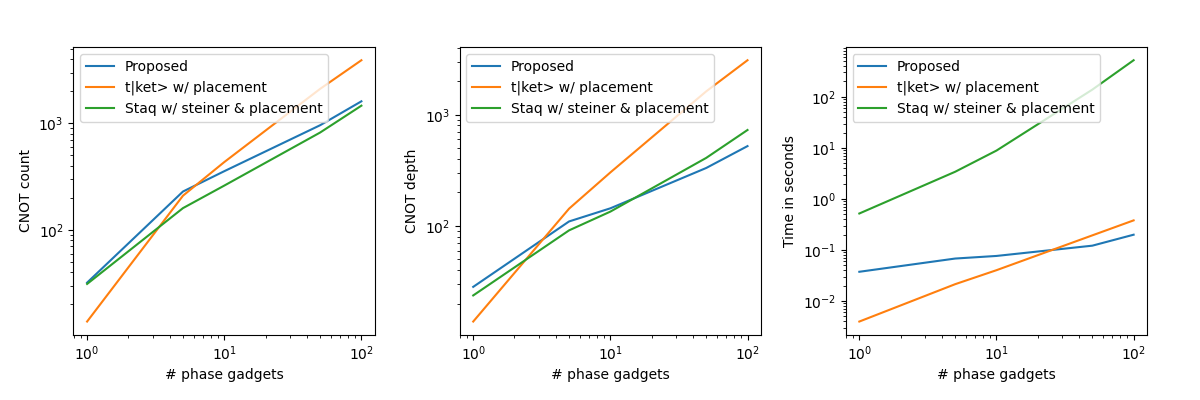

data/rigetti_16q_aspen_gadget_scaling_with_mapping.csv CNOT count
method  proposed     staq     tket
# Rz                              
1          32.00    31.10    13.80
5         229.30   160.20   209.55
10        355.80   260.65   433.25
50        961.05   820.80  2109.35
100      1611.90  1466.85  3917.60
data/rigetti_16q_aspen_gadget_scaling_with_mapping.csv CNOT depth
method  proposed    staq     tket
# Rz                             
1          28.30   23.70    13.80
5         109.70   91.20   142.95
10        143.95  134.45   302.65
50        331.90  409.00  1622.45
100       522.05  728.80  3090.60
data/rigetti_16q_aspen_gadget_scaling_with_mapping.csv Time in seconds
method  proposed        staq      tket
# Rz                                  
1       0.037409    0.518371  0.003963
5       0.067964    3.407358  0.021384
10      0.076396    8.853887  0.040176
50      0.121450  138.447664  0.193339
100     0.199177  521.102112  0.380060


In [10]:
legend_dict[STAQ] = "Staq w/ steiner & placement"
plot_results("data/rigetti_16q_aspen_gadget_scaling_with_mapping.csv", GADGET_SCALING, [PROPOSED, TKET, STAQ], "Scaling of the number of phase gadgets on the 16 qubit Rigetti Aspen architecture", xlog=True, ylog=True)
plot_results("data/ibmq_singapore_gadget_scaling_with_mapping.csv", GADGET_SCALING, [PROPOSED, TKET, STAQ], "Scaling of the number of phase gadgets on the 20 qubit IBM singapore architecture", xlog=True, ylog=True)
legend_dict[STAQ] = "Staq w/ steiner w/o placement"

<IPython.core.display.Javascript object>


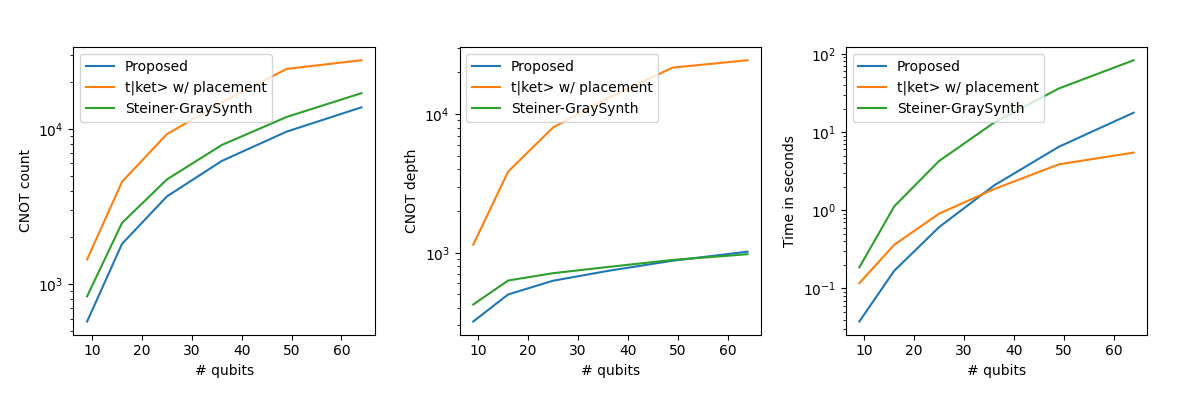

data/line_qubit_scaling.csv CNOT count
method      nash  proposed      tket
qubits                              
9         836.45    575.40   1444.30
16       2480.10   1818.75   4565.50
25       4724.60   3673.35   9240.80
36       7866.50   6211.55  14761.20
49      11920.00   9592.70  24291.45
64      16960.45  13750.00  27632.10
data/line_qubit_scaling.csv CNOT depth
method    nash  proposed      tket
qubits                            
9       422.75    318.65   1142.75
16      629.95    499.85   3846.85
25      711.55    627.50   8004.30
36      788.75    739.30  13074.70
49      886.60    875.40  21651.35
64      975.30   1017.30  24473.65
data/line_qubit_scaling.csv Time in seconds
method       nash   proposed      tket
qubits                                
9        0.185756   0.037694  0.116553
16       1.121442   0.168182  0.361905
25       4.268683   0.608883  0.905081
36      13.197604   2.071796  1.862617
49      36.098925   6.483805  3.867473
64      82.993962  17.706266 

<IPython.core.display.Javascript object>


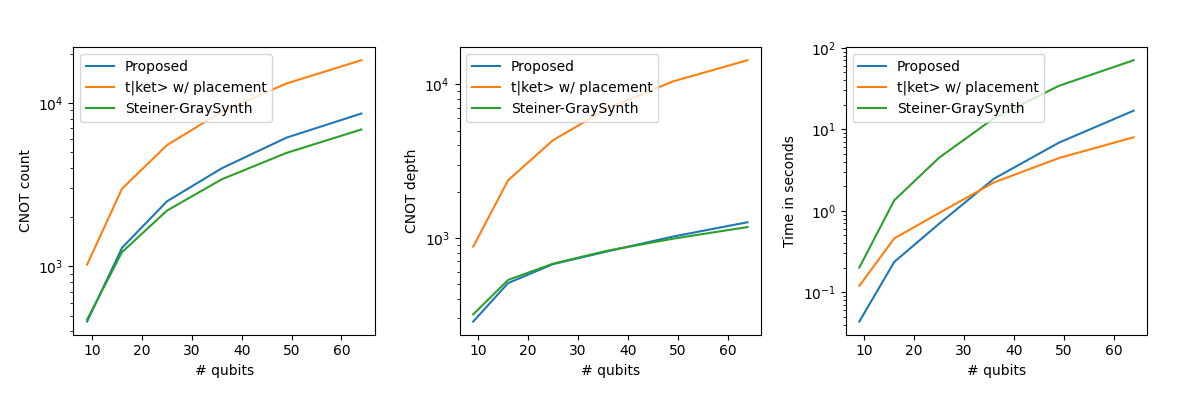

data/square_qubit_scaling.csv CNOT count
method     nash  proposed      tket
qubits                             
9        472.15    459.35   1025.65
16      1222.50   1299.00   2986.20
25      2191.35   2497.65   5514.35
36      3409.85   3982.25   8842.65
49      4948.05   6135.10  13171.00
64      6881.55   8615.05  18259.70
data/square_qubit_scaling.csv CNOT depth
method     nash  proposed      tket
qubits                             
9        316.10    283.85    874.75
16       530.50    505.95   2372.30
25       677.30    672.35   4327.40
36       824.35    815.60   6993.00
49       984.55   1016.65  10457.15
64      1174.30   1261.85  14393.05
data/square_qubit_scaling.csv Time in seconds
method       nash   proposed      tket
qubits                                
9        0.201205   0.043717  0.119784
16       1.342416   0.235684  0.457886
25       4.478667   0.693175  0.938922
36      13.678582   2.475038  2.227234
49      34.105806   6.843369  4.432224
64      70.358184  16.9

<IPython.core.display.Javascript object>


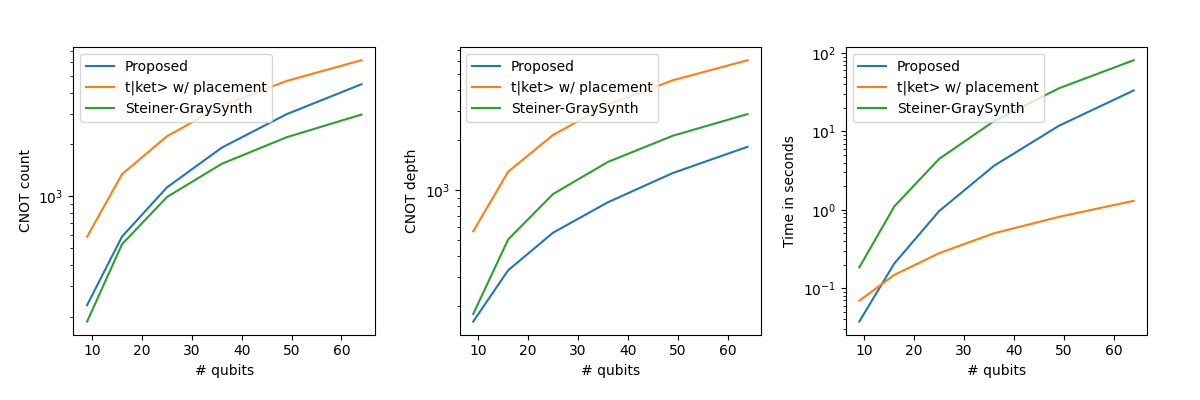

data/fully_connected_qubit_scaling.csv CNOT count
method     nash  proposed    tket
qubits                           
9        187.75    233.75   583.3
16       527.05    583.85  1343.4
25       990.10   1125.55  2227.7
36      1543.40   1915.45  3351.1
49      2200.75   2994.10  4668.5
64      2978.95   4466.60  6155.9
data/fully_connected_qubit_scaling.csv CNOT depth
method     nash  proposed     tket
qubits                            
9        180.05    162.25   566.90
16       506.25    330.15  1294.60
25       949.85    555.80  2155.15
36      1483.15    847.85  3281.25
49      2131.25   1271.05  4599.60
64      2880.10   1829.50  6076.20
data/fully_connected_qubit_scaling.csv Time in seconds
method       nash   proposed      tket
qubits                                
9        0.184173   0.037610  0.069336
16       1.103121   0.206357  0.147795
25       4.463255   0.963269  0.280303
36      13.501274   3.642107  0.502349
49      35.417092  11.776802  0.812737
64      80.855898  3

In [11]:
plot_results("data/line_qubit_scaling.csv", QUBIT_SCALING, [PROPOSED, TKET, NASH], "Scaling of line architectures with different number of qubits", ylog=True)
plot_results("data/square_qubit_scaling.csv", QUBIT_SCALING, [PROPOSED, TKET, NASH], "Scaling of square architectures with different number of qubits", ylog=True)
plot_results("data/fully_connected_qubit_scaling.csv", QUBIT_SCALING, [PROPOSED, TKET, NASH], "Scaling of unconstrained architectures with different number of qubits", ylog=True)

<IPython.core.display.Javascript object>


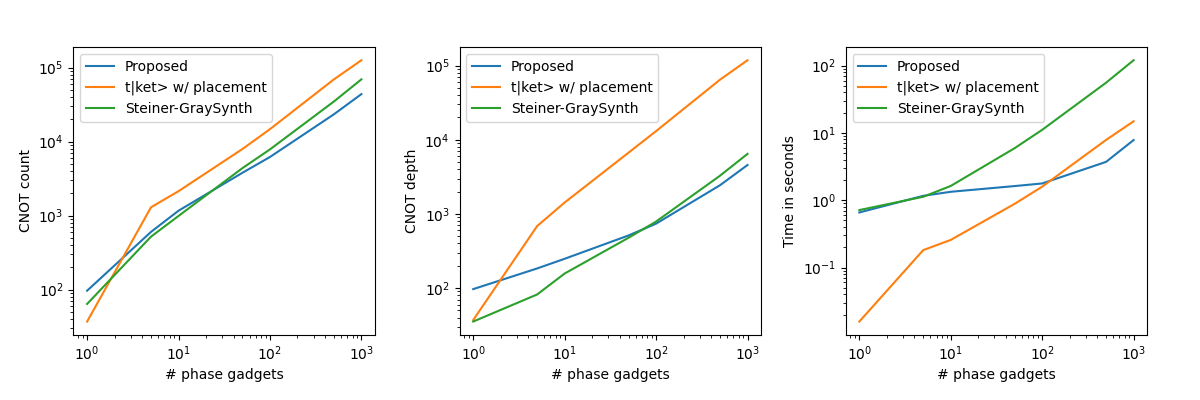

data/line_gadget_scaling.csv CNOT count
method      nash  proposed       tket
# Rz                                 
1          64.15     96.90      37.10
5         521.10    603.80    1298.70
10        991.85   1167.45    2142.80
50       4391.70   3800.50    7960.45
100      7866.50   6211.55   14761.20
500     34883.95  23425.10   69417.10
1000    69584.50  43934.05  126095.50
data/line_gadget_scaling.csv CNOT depth
method     nash  proposed       tket
# Rz                                
1         35.40     96.90      37.10
5         82.00    183.95     684.85
10       157.15    248.40    1424.30
50       477.30    512.50    6700.05
100      788.75    739.30   13074.70
500     3272.30   2435.75   64493.35
1000    6446.50   4564.45  118035.55
data/line_gadget_scaling.csv Time in seconds
method        nash  proposed       tket
# Rz                                   
1         0.714076  0.657939   0.015724
5         1.125978  1.162526   0.181351
10        1.630722  1.335499   0.257168


<IPython.core.display.Javascript object>


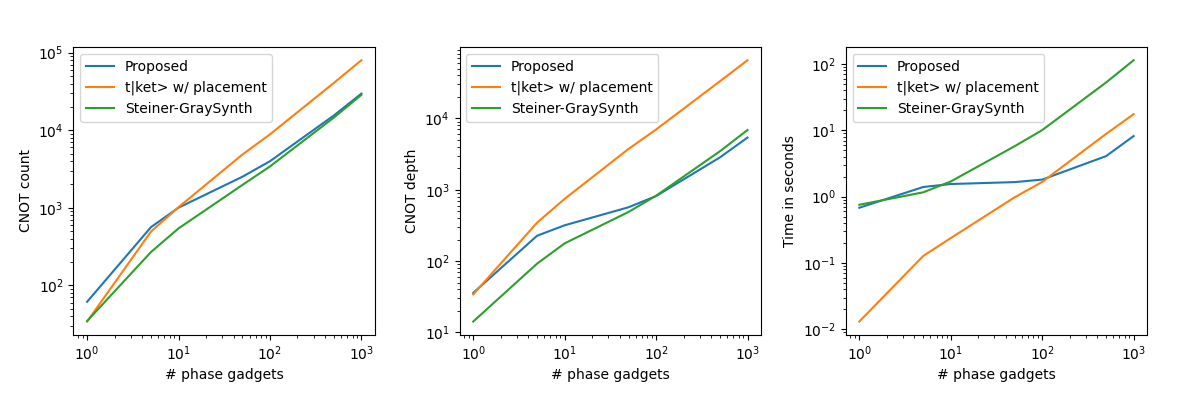

data/square_gadget_scaling.csv CNOT count
method      nash  proposed      tket
# Rz                                
1          34.60     61.30     34.10
5         268.80    562.95    493.45
10        541.70   1002.75   1017.65
50       1969.35   2512.10   4859.05
100      3409.85   3982.25   8842.65
500     14560.45  15492.85  40734.55
1000    28530.30  29621.30  79821.90
data/square_gadget_scaling.csv CNOT depth
method     nash  proposed      tket
# Rz                               
1         14.20     35.80     34.10
5         92.15    226.65    346.30
10       177.15    317.45    745.20
50       488.35    568.20   3737.90
100      824.35    815.60   6993.00
500     3469.65   2844.85  33232.65
1000    6876.90   5390.25  65423.70
data/square_gadget_scaling.csv Time in seconds
method        nash  proposed       tket
# Rz                                   
1         0.755324  0.681152   0.013116
5         1.163971  1.399781   0.127793
10        1.695047  1.551633   0.237600
50        5.

<IPython.core.display.Javascript object>


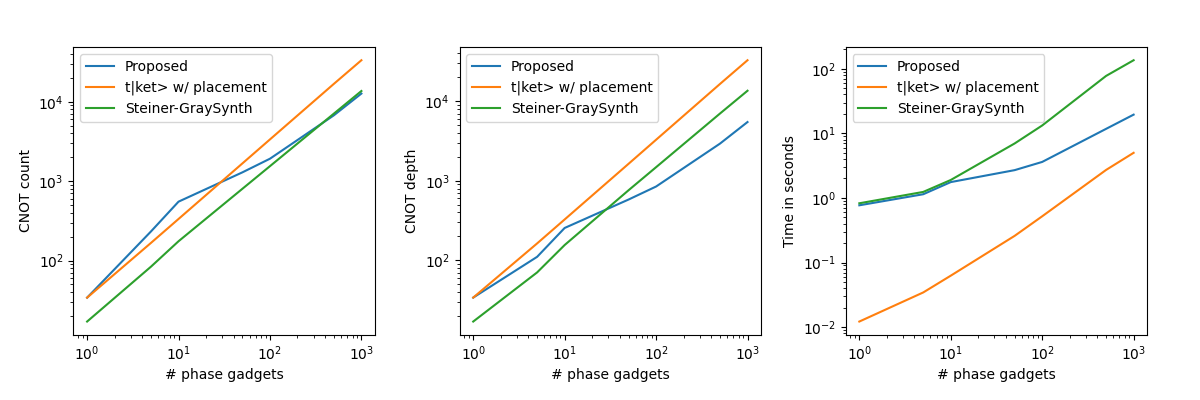

data/fully_connected_gadget_scaling.csv CNOT count
method      nash  proposed     tket
# Rz                               
1          17.05     34.10     34.1
5          83.80    232.70    166.9
10        174.95    551.40    333.8
50        801.60   1290.25   1673.0
100      1543.40   1915.45   3351.1
500      7081.75   6741.75  16781.8
1000    13642.20  12660.40  33291.1
data/fully_connected_gadget_scaling.csv CNOT depth
method      nash  proposed      tket
# Rz                                
1          17.05     34.10     34.10
5          70.65    110.90    163.50
10        156.00    255.60    326.95
50        761.30    581.80   1636.20
100      1483.15    847.85   3281.25
500      7006.85   2935.00  16489.55
1000    13550.90   5479.05  32759.35
data/fully_connected_gadget_scaling.csv Time in seconds
method        nash   proposed      tket
# Rz                                   
1         0.826369   0.769061  0.012178
5         1.239069   1.140879  0.034376
10        1.896684   1.75

In [12]:
plot_results("data/line_gadget_scaling.csv", GADGET_SCALING, [PROPOSED, TKET, NASH],"Scaling of the number of phase gadgets on a 36 qubit line architecture", xlog=True, ylog=True)
plot_results("data/square_gadget_scaling.csv", GADGET_SCALING, [PROPOSED, TKET, NASH],"Scaling of the number of phase gadgets on a 36 qubit square architecture", xlog=True, ylog=True)
plot_results("data/fully_connected_gadget_scaling.csv", GADGET_SCALING, [PROPOSED, TKET, NASH],"Scaling of the number of phase gadgets on a 36 qubit unconstrained architecture", xlog=True, ylog=True)